In [ ]:
  !pip install -U datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import Counter
import re
import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
dataset = load_dataset("udmurtNLP/udmurt-russian-parallel-corpora")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/101833 [00:00<?, ? examples/s]

In [ ]:
df = pd.DataFrame(dataset['train'])

In [ ]:
def count_words(text, lang='other'):
    #Количество слов
    #For agglutinative languages, we may need complex word segmenter based on morphological analysis.(?)
    return len(text.split())

def count_chars(text):
    #символы
    return len(text)

def count_tokens(text, tokenizer=None):
    #токен
    if tokenizer is None:
        return len(text.split())
    else:
        return len(tokenizer.tokenize(text))

In [ ]:
# 1. EDA
# инициализация по языкам
stats = {'udm': {'words': 0, 'chars': 0, 'tokens': 0, 'sent_lengths_words': [], 'sent_lengths_chars': [], 'sent_lengths_tokens': []},
      'ru': {'words': 0, 'chars': 0, 'tokens': 0, 'sent_lengths_words': [], 'sent_lengths_chars': [], 'sent_lengths_tokens': []}}

In [ ]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [ ]:
for index, row in df.iterrows():
    udm_text = row['udm']
    ru_text = row['ru']

    # udm
    udm_word_count = count_words(udm_text)
    udm_char_count = count_chars(udm_text)
    udm_token_count = count_tokens(udm_text, tokenizer)
    stats['udm']['words'] += udm_word_count
    stats['udm']['chars'] += udm_char_count
    stats['udm']['tokens'] += udm_token_count
    stats['udm']['sent_lengths_words'].append(udm_word_count)
    stats['udm']['sent_lengths_chars'].append(udm_char_count)
    stats['udm']['sent_lengths_tokens'].append(udm_token_count)

    # ru
    ru_word_count = count_words(ru_text)
    ru_char_count = count_chars(ru_text)
    ru_token_count = count_tokens(ru_text, tokenizer)
    stats['ru']['words'] += ru_word_count
    stats['ru']['chars'] += ru_char_count
    stats['ru']['tokens'] += ru_token_count
    stats['ru']['sent_lengths_words'].append(ru_word_count)
    stats['ru']['sent_lengths_chars'].append(ru_char_count)
    stats['ru']['sent_lengths_tokens'].append(ru_token_count)

# объём
for lang in ['udm', 'ru']:
    print(f"{lang.upper()}:")
    print(f"words:{stats[lang]['words']}")
    print(f"chars:{stats[lang]['chars']}")
    print(f"tokens:{stats[lang]['tokens']}")

UDM:
words:1043734
chars:6762043
tokens:1043734
RU:
words:1083595
chars:6623831
tokens:1083595


## Phase 2

In [ ]:
# 1. Найти выбросы по длинам предложений
def detect_length_outliers(df):
    # Вычисляем длину предложений в токенах
    df['udm_len'] = df['udm'].apply(lambda x: len(x.split()))
    df['ru_len'] = df['ru'].apply(lambda x: len(x.split()))

    # Определяем выбросы для удмуртского языка
    udm_q1 = df['udm_len'].quantile(0.25)
    udm_q3 = df['udm_len'].quantile(0.75)
    udm_iqr = udm_q3 - udm_q1
    udm_outliers = df[(df['udm_len'] < udm_q1 - 1.5*udm_iqr) |
                     (df['udm_len'] > udm_q3 + 1.5*udm_iqr)]

    # Определяем выбросы для русского языка
    ru_q1 = df['ru_len'].quantile(0.25)
    ru_q3 = df['ru_len'].quantile(0.75)
    ru_iqr = ru_q3 - ru_q1
    ru_outliers = df[(df['ru_len'] < ru_q1 - 1.5*ru_iqr) |
                     (df['ru_len'] > ru_q3 + 1.5*ru_iqr)]

    # Объединяем выбросы
    all_outliers = pd.concat([udm_outliers, ru_outliers]).drop_duplicates()

    return all_outliers

# Выводим примеры выбросов
outliers_df = detect_length_outliers(df)
print(f"Найдено выбросов: {len(outliers_df)}")
outliers_df[['udm', 'ru', 'udm_len', 'ru_len']].head(10)

Найдено выбросов: 5292


,udm,ru,udm_len,ru_len
0,"Рабочийёслэн слободказы вадьсын, ӵыно, вӧё омы...","Каждый день над рабочей слободкой, в дымном, м...",33,35
1,Кезьыт ӵукна ӝомытын соос изэн вӧлдымтэ урам к...,В холодном сумраке они шли по немощеной улице ...,27,26
5,"Ӝыт, шунды пуксьыку, солэн горд сиосыз коркаос...","Вечером, когда садилось солнце и на стеклах до...",45,44
8,"Нунал пытьыез кылёнтэм ӵушемын улонысь, адями ...","День бесследно вычеркнут из жизни, человек сде...",29,27
12,"Ӝыт соос мылзы потытэк юмшаллязы урамъёс кузя,...","Вечером лениво гуляли по улицам, и тот, кто им...",30,28
23,"Адямиос, атайёссы кадь ик, таӵе висись мылкыды...","Люди рождались с этою болезнью души, наследуя ...",28,29
24,Праздникъёсы егитъёс доразы бер уин берытскылӥ...,По праздникам молодежь являлась домой поздно н...,36,35
26,Валанзэс ыштыса пограм пиоссэс соос кытысь ке ...,Они отыскивали их где-нибудь под забором на ул...,40,46
27,"Егитъёсты туж зол тышкаськыло но жугыло вал, о...","Ругали и били детей тяжело, но пьянство и драк...",36,31
28,"Улон котьку сыӵе вал, — со пож визылэн аръёс б...","Жизнь всегда была такова, — она ровно и медлен...",34,34


In [ ]:
# 2. Таблица с косинусным расстоянием
!pip install transformers sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import torch
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = SentenceTransformer('lingtrain/labse-udmurt').to(device)

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
# Функция для пакетной обработки
def batch_encode(texts, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Кодирование предложений"):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, convert_to_tensor=True, device=device)
        embeddings.append(emb.cpu())
    return torch.cat(embeddings)

# Кодирование предложений пачками
udm_embeddings = batch_encode(df['udm'].tolist())
ru_embeddings = batch_encode(df['ru'].tolist())

# Вычисление косинусного расстояния
cosine_dists = []
for udm, ru in tqdm(zip(udm_embeddings, ru_embeddings), total=len(df), desc="Расчет расстояний"):
    similarity = torch.nn.functional.cosine_similarity(udm, ru, dim=0)
    cosine_dists.append(float(1 - similarity))  # Преобразуем расстояние в диапазон [0, 2]

# Добавление столбца в DataFrame
df['cosine_distance'] = cosine_dists

Расчет расстояний: 100%|██████████| 101833/101833 [00:03<00:00, 28316.16it/s]


In [ ]:
# Сохраняем результат
df.to_csv('udmurt_russian_with_distances.csv', index=False)

In [ ]:
# # Загружаем модель ☠️☠️☠️
# model = SentenceTransformer('lingtrain/labse-udmurt')

# def calculate_cosine_distance(row):
#     # Получаем эмбеддинги
#     udm_embedding = model.encode(row['udm'], convert_to_tensor=False)
#     ru_embedding = model.encode(row['ru'], convert_to_tensor=False)

#     # Вычисляем косинусное расстояние (0-1)
#     cos_sim = 1 - cosine(udm_embedding, ru_embedding)
#     cos_distance = 1 - cos_sim  # расстояние = 1 - сходство

#     return round(cos_distance, 4)

# # Добавляем новую колонку (это может занять время)
# df['cosine_distance'] = df.apply(calculate_cosine_distance, axis=1)

# # Сохраняем результат
# df.to_csv('udmurt_russian_with_distances.csv', index=False)

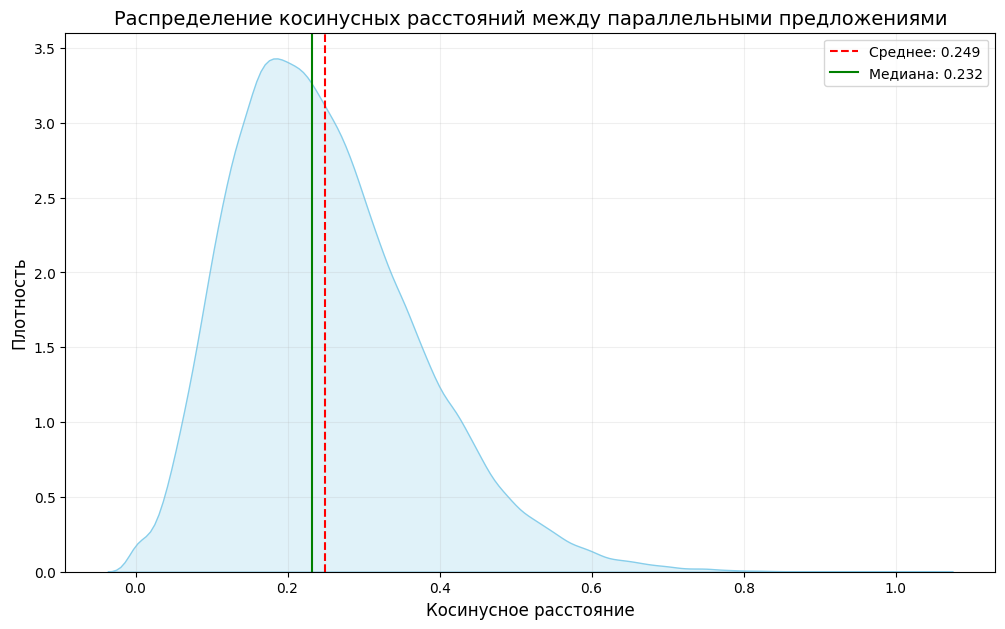

In [ ]:
# 3. Визуализация распределения косинусных расстояний
plt.figure(figsize=(12, 7))
sns.kdeplot(df['cosine_distance'], fill=True, color='skyblue')

# Рассчитываем статистики
mean_dist = df['cosine_distance'].mean()
median_dist = df['cosine_distance'].median()

# Добавляем линии статистик
plt.axvline(mean_dist, color='red', linestyle='--', label=f'Среднее: {mean_dist:.3f}')
plt.axvline(median_dist, color='green', linestyle='-', label=f'Медиана: {median_dist:.3f}')

plt.title('Распределение косинусных расстояний между параллельными предложениями', fontsize=14)
plt.xlabel('Косинусное расстояние', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [ ]:
# 4. Примеры с низким косинусным расстоянием
low_distance_samples = df.nsmallest(20, 'cosine_distance')

# Выводим примеры
for idx, row in low_distance_samples.iterrows():
    print(f"Пример #{idx+1} | Расстояние: {row['cosine_distance']:.4f}")
    print(f"Удмуртский: {row['udm']}")
    print(f"Русский: {row['ru']}")
    print("-" * 80)


Пример #11179 | Расстояние: -0.0000
Удмуртский: — Вова?
Русский: — Вова?
--------------------------------------------------------------------------------

Пример #16722 | Расстояние: -0.0000
Удмуртский: — Тю!
Русский: — Тю!
--------------------------------------------------------------------------------

Пример #17479 | Расстояние: -0.0000
Удмуртский: — Важенин Влас Иванович!
Русский: — Важенин Влас Иванович!
--------------------------------------------------------------------------------

Пример #18300 | Расстояние: -0.0000
Удмуртский: Гражданин Лазарев!.. Жученков!.. Зябрев!..
Русский: Гражданин Лазарев!.. Жученков!.. Зябрев!..
--------------------------------------------------------------------------------

Пример #18596 | Расстояние: -0.0000
Удмуртский: — Винтовка.
Русский: — Винтовка.
--------------------------------------------------------------------------------

Пример #25091 | Расстояние: -0.0000
Удмуртский: Тимка!
Русский: Тимка!
---------------------------------------------

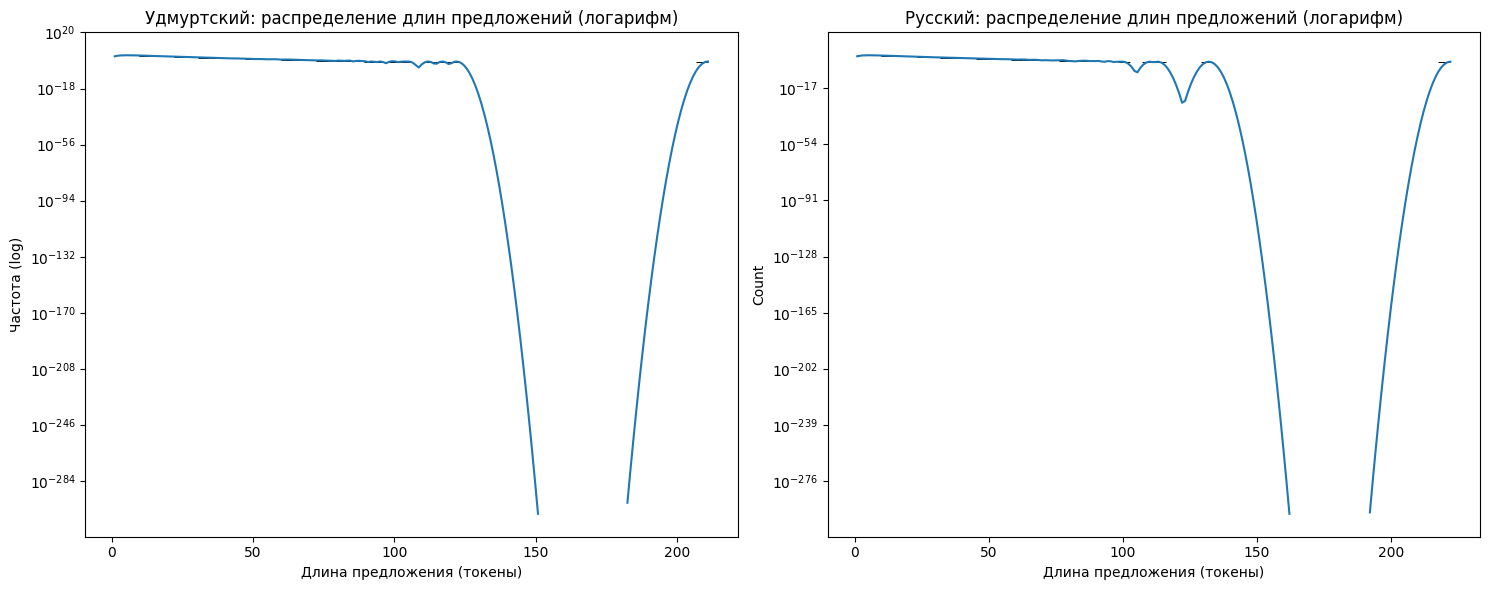

In [ ]:
# 5. Логарифмирование графиков распределения длин
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Для удмуртского языка
sns.histplot(df['udm_len'], bins=50, kde=True, log_scale=[False, True], ax=axes[0])
axes[0].set_title('Удмуртский: распределение длин предложений (логарифм)', fontsize=12)
axes[0].set_xlabel('Длина предложения (токены)', fontsize=10)
axes[0].set_ylabel('Частота (log)', fontsize=10)

# Для русского языка
sns.histplot(df['ru_len'], bins=50, kde=True, log_scale=[False, True], ax=axes[1])
axes[1].set_title('Русский: распределение длин предложений (логарифм)', fontsize=12)
axes[1].set_xlabel('Длина предложения (токены)', fontsize=10)

plt.tight_layout()
plt.show()